<h2><center>Automated Workflow of Storm Surge Modeling and Validation</center></h2>

<h3><center>Jinpai (Max) Zhao</center></h3>

<hr style="border:1.5px solid gray">

Dependency acknowledgement: successful execution of this notebook requires a working [python](https://www.python.org) version 3.0 or later with [numpy](https://numpy.org), [matplotlib](https://matplotlib.org), and [pandas](https://pandas.pydata.org/docs/getting_started/install.html) installed. You should also install Clawpack. Instructions for installing Clawpack can be found [here](http://www.clawpack.org/installing.html). For temporal and spatial visualization of storm path, [pyproj](https://pyproj4.github.io/pyproj/stable/), [geopandas](https://geopandas.org/en/stable/) and [missingno](https://pypi.org/project/missingno/) packages need to be installed.

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import clawpack.geoclaw.util
from math import sin, cos, sqrt, atan2, radians
import re
import os
import pyproj
import geopandas
from shapely.geometry import Point
import missingno as msn
import seaborn as sns
%matplotlib inline

<hr style="border:1.5px solid gray">

### Background and Motivation

With the rapid advancement of computational science, we are able to construct all kinds of natural systems using mathematical models and numerical methods. Coastal hazards, which lies under the domain, is considered to be a major concern because nearly 40% of the world population reside close to the coastline. Among all coastal hazards, the most common, wide-spread hazard is the storm surge, which is the abnormal and significant rise of sea water level caused by storm systems like hurricanes and typhoons. Storm surges can be disastrous to coastal communities.

The **Clawpack** (Conservation Law Package) software suite is designed to solve nonlinear conservation law problems, balance laws, and many more other hyperbolic partial differential equations which are not necessarily in conservation form. **GeoClaw**, a variant of the Clawpack software, is developed to specifically solve the two-dimensional shallow water equations over topography for modeling various geophysical flows like hurricane, tsunami, or dam break. 

We will focus on modeling and validating water surge generated by storm systems using GeoClaw. The documentation for the original workflow can be found [here](https://github.com/mandli/surge-examples/tree/master/storm_setup). However, given the complexity of the procedure which includes data collection, run-time parameters selection, water level gauges selection, and etc., as well as the long program execution time, a python program was consequently developed to assist users on visualizing and auto-selecting most of the data before running the program. 

<font size="2">*Reference: Jinpai Zhao. Storm Surge Modeling and Validation. [Poster](https://github.com/MaxPaiPai/Research-Symposium-22/blob/main/Poster_Jinpai%20(Max)%20Zhao.pdf) Presentation at Columbia University Engineering Symposium, 2022*</font>


<hr style="border:1.5px solid gray">

### Program overview & Execution guide

The program consists of three main featured functions which are `generate_time`, `generate_gauge`, and `generate_significance`, along with several helper functions. Specifically, `generate_time` reports availability of storm specific data, `generate_gauge` reports details of auto-selected stations from NOAA stations’ metadata for validation studies, and `generate_significance` reports maximum surge detected and shortest distance to storm eye at each recommended station for users to target abnormality. Storm data are fetched from [NOAA archive](https://ftp.nhc.noaa.gov/atcf/archive/) as ATCF format. Metadata of water level stations are from [CO-OPS Metadata API (MDAPI)](https://api.tidesandcurrents.noaa.gov/mdapi/prod/). (As shown in the cell below)

There are two ways to execute the program:

**1 (Recommended)**: Follow and run to the end of this notebook. Results and outputs will be displayed upon execution of cells. 

**2**: Execute the `auto_analysis.py` directly. This will produce a system logger file located in the same folder of your `auto_analysis.py`. The logger file contains all the results and outputs. However, due to the format of the logger file, matplotlib package cannot be made compatible. Therefore, for better visualization, please prioritize the first method. 

In [2]:
# Fetch storm data & station metadata
def generate_storm_data(number):
    """
    @param: storm number
    @return: storm specific data, data in Pandas series format
    """ 
    storm = pd.DataFrame(pd.read_csv(str('http://ftp.nhc.noaa.gov/atcf/archive/2021/b'+number+'.dat.gz'),
            sep=':', header=None,))

    storm = storm[0].str.split(',')

    return storm

def generate_station_data():
    """
    @param: none
    @return: Metadata for NOAA water level gauges, data in Pandas dataframe format
    """ 
    station_meta = pd.read_json('https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json')

    return station_meta

First, let's choose a storm of our interest. I choose Hurricane Elsa in 2021 just as an example. Feel free to change the storm number to match the storm you would like to study. What is a numbered storm? The National Hurricane Center (NHC) gives a number to each new tropical depression that forms in the Atlantic basin. Details can be found in the [National Hurricane Center website](https://www.nhc.noaa.gov). Then we need to fetch the storm specific data corresponding to our storm. The format of the storm data is Pandas series. We also need to specify the landfall time. There could be more than one landfall for one storm, or there might not even be a landfall. Therefore, the landfall time needs to be determined subjectively by the user. 

In [3]:
# Hurricane number for Elsa 2021:
number = 'al052021'

# Fetch storm data for Elsa
storm = generate_storm_data(number)

# Define landfall time, format: year+month+date+time (no space in between)
user_in = '2021070714'
print('Landfall time you selected was', datetime(int(user_in[0:4]),int(user_in[4:6]),int(user_in[6:8]),int(user_in[8:])), 'Please double check.')

Landfall time you selected was 2021-07-07 14:00:00 Please double check.


### Have a broad picture of your data availability

In [4]:
def generate_time(storm, user_in):
    """
    @param: storm data in pandas series, landfall time in strings
    @return: tuple of (s_date, e_date, delta_days, before_landfall, after_landfall, user_in)
    """ 
    try:

        land_y = int(user_in[0:4])
        land_m = int(user_in[4:6])
        land_d = int(user_in[6:8])
        land_t = int(user_in[8:])

        data_start_y = int(storm[0][2][1:5])
        data_start_m = int(storm[0][2][5:7])
        data_start_d = int(storm[0][2][7:9])
        data_start_t = int(storm[0][2][9:])

        data_end_y = int(storm[len(storm)-1][2][1:5])
        data_end_m = int(storm[len(storm)-1][2][5:7])
        data_end_d = int(storm[len(storm)-1][2][7:9])
        data_end_t = int(storm[len(storm)-1][2][9:])

        l_date = datetime(land_y, land_m, land_d, land_t)
        s_date = datetime(data_start_y, data_start_m, data_start_d, data_start_t)
        e_date = datetime(data_end_y, data_end_m, data_end_d, data_end_t)

        before_landfall = float((l_date - s_date).total_seconds()/86400)
        after_landfall = float((e_date - l_date).total_seconds()/86400)
        delta_days = float((e_date - s_date).total_seconds()/86400)

        return (s_date, e_date, delta_days, round(before_landfall,2), round(after_landfall,2), user_in)
    except:
        print('Something was wrong with data...')

Now let's use the function with the storm data and landfall time to obtain a general view of the temporal behavior of the storm.

In [5]:
report_time = generate_time(storm, user_in)
print('Data for the storm is available starting at', report_time[0])
print('Data for the storm is NOT available after', report_time[1])
print('Landfall time you selected was', datetime(int(report_time[5][0:4]),int(report_time[5][4:6]),int(report_time[5][6:8]),int(report_time[5][8:])))
print('In total,', report_time[2], 'days can be simulated.')
print(report_time[3], 'days are before landfall.')
print(report_time[4], 'days are after landfall.')

Data for the storm is available starting at 2021-06-30 18:00:00
Data for the storm is NOT available after 2021-07-10 06:00:00
Landfall time you selected was 2021-07-07 14:00:00
In total, 9.5 days can be simulated.
6.83 days are before landfall.
2.67 days are after landfall.


To have a even better visualization of the storm data both temporally and spatially, we can take advantage of matplotlib inline and the geopandas package to simulate the storm path. Boarder data of the United States can be downloaded from [here](https://eric.clst.org/tech/usgeojson/). Please make sure the Geojson file resides in the same directory as this notebook. 

In [6]:
# Get US boarder data and use geopandas to read in the data
country = geopandas.read_file("gz_2010_us_040_00_500k.json")
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


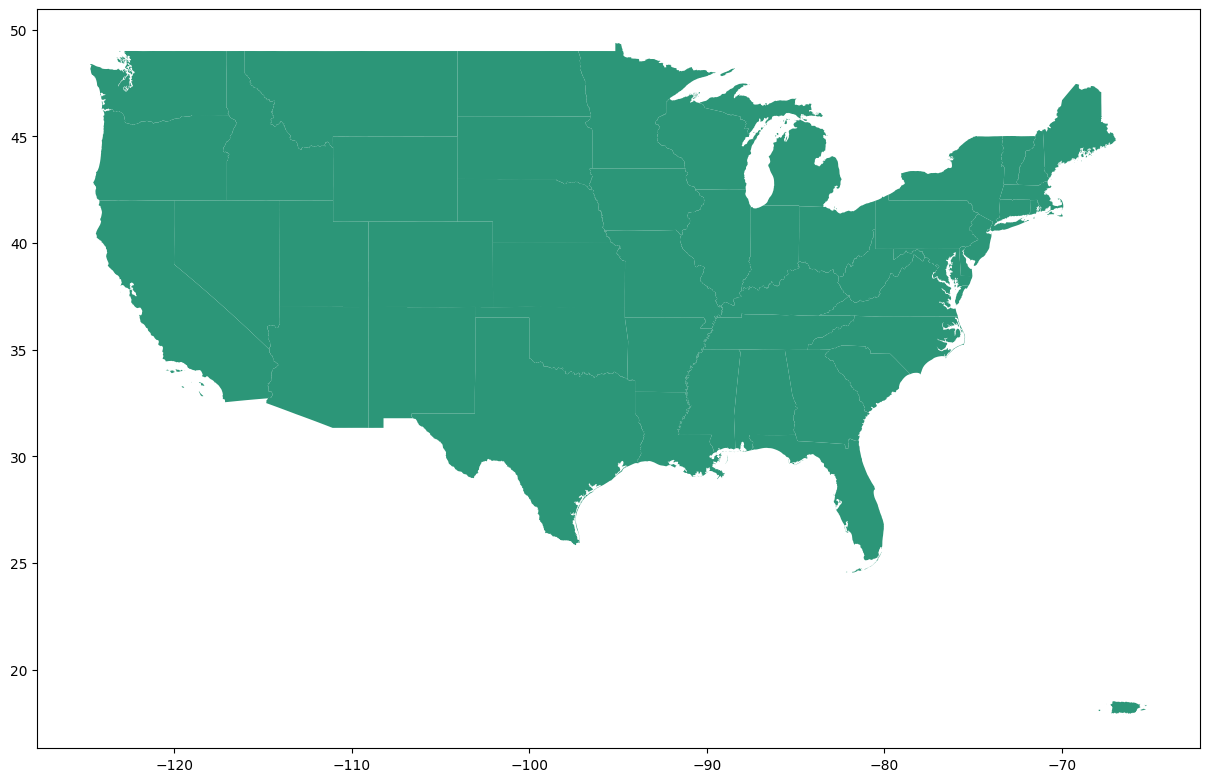

In [9]:
# Check the data is working. Alaska and Hawaii are excluded from the plot due to best visual effect.
country[country['NAME'].isin(['Alaska', 'Hawaii'])==False].plot(color = '#2C9678', figsize=(15,10))
plt.show()

Now we add the storm specific data onto this frame.

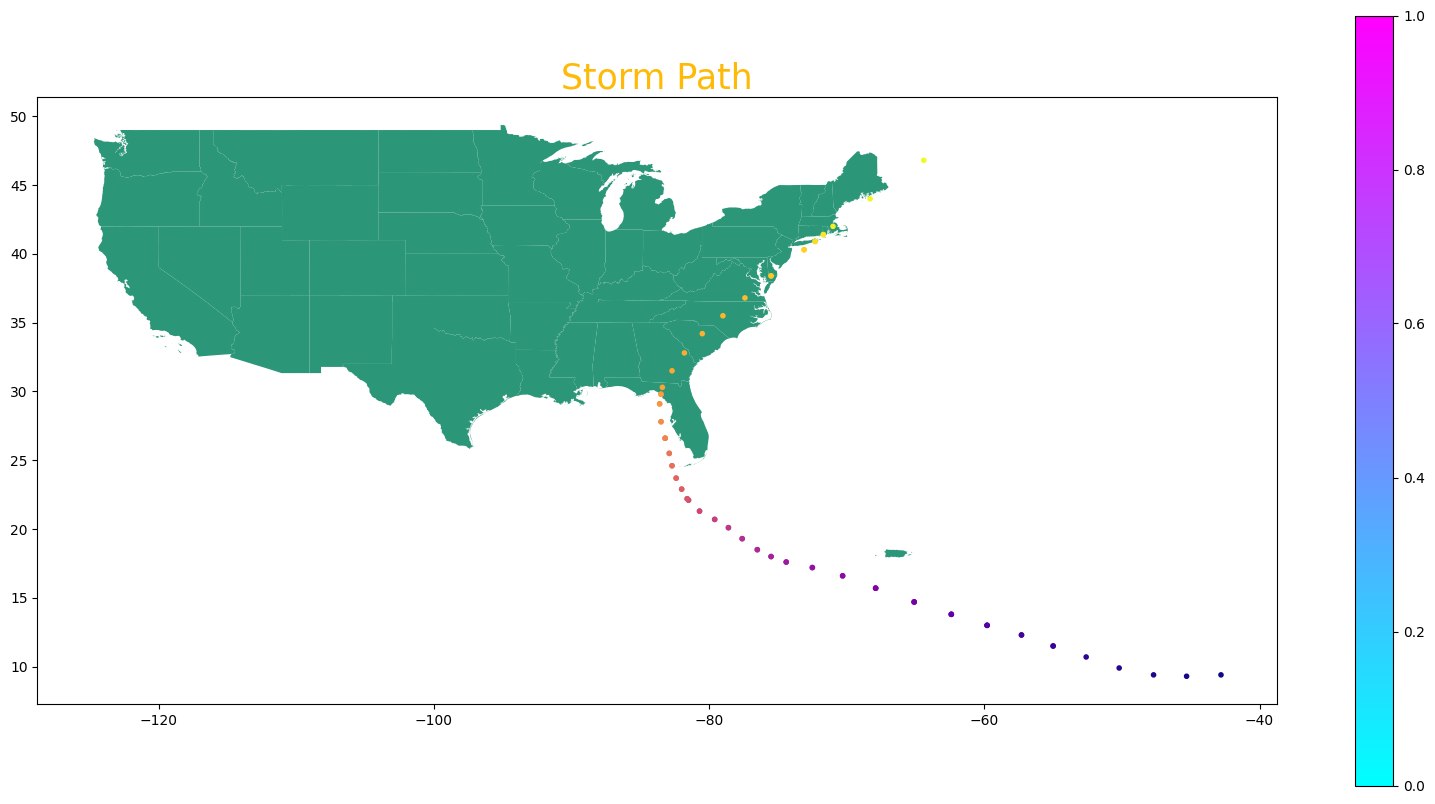

In [27]:
# Extract coordinates information from storm data
location = []
for i in range(len(storm)):
    lat_raw = re.findall(r'\d+',storm[i][6])
    lon_raw = re.findall(r'\d+',storm[i][7])
    lat = float(int(lat_raw[0])/10)
    lon = float(int(lon_raw[0])/10)
    location.append((-lon, lat))
d = {'coord': location}
df = pd.DataFrame(data=d)

# Change coordinates to GeoPoints
df['coord'] = df['coord'].apply(Point)

# Geopandas read in this new coordinate dataframe
df = geopandas.GeoDataFrame(df, geometry='coord')

# Plot storm data on top of the topography frame
fig, ax = plt.subplots(1, figsize=(20,10))
base = country[country['NAME'].isin(['Alaska', 'Hawaii'])==False].plot(color = '#2C9678', figsize=(60,30), ax = ax)
sm = plt.cm.ScalarMappable(cmap='cool')
plt.colorbar(sm)

df.plot(ax = base, legend=True, c=location[0], cmap='plasma',marker='.', )
ax.set_title('Storm Path', color = '#FEBA07', fontsize=25)
plt.show()

### Auto-selected water level gugaes for your storm

Now we know the storm data availability, and we know how the storm travels, we are ready to select water level gauges for validation studies. In addition to the `generate_gauge` function, a helper function to convert distance in latitude and longitude to kilometers is also introduced to prepare for the final feature. We also need to fetch the stations' metadata.

In [33]:
# Fetch stations' metadata, data in Pandas dataframe format
station_meta = generate_station_data()

In [28]:
def convert_km(lat_1, lng_1, lat_2, lng_2):
    """
    @param: latitude and longitude of two locations: (lat_1, lng_1) for the first location, (lat_2, lng_2) for the second location
    @return: distance between the two locations in kilometers
    """ 
    radius = 6371.0

    d_lat = radians(lat_2) - radians(lat_1)
    d_lng = radians(lng_2) - radians(lng_1)
    
    var_1 = sin(d_lat / 2)**2 + cos(radians(lat_1)) * cos(radians(lat_2)) * sin(d_lng / 2)**2
    var_2 = 2 * atan2(sqrt(var_1), sqrt(1 - var_1))
   
    distance = radius * var_2

    return distance

In [29]:
def generate_gauge(metadata, storm):
    """
    @param: stations metadata, storm specific data
    @return: a dictionary of recommended gauges and their specific information. Gauge names are key and [station id, latitude, longitude, distance to storm eye] are values
    """ 
    location = []
    for i in range(len(storm)):
        lat_raw = re.findall(r'\d+',storm[i][6])
        lon_raw = re.findall(r'\d+',storm[i][7])
        lat = float(int(lat_raw[0])/10)
        lon = float(int(lon_raw[0])/10)
        location.append((lat, lon))

    gauge = {}
    for i in location:
        for j in range(len(metadata)):
            if (i[0]-0.5)<metadata['stations'][j]['lat']<(i[0]+0.5):
                if (-i[1]-1)<metadata['stations'][j]['lng']<(-i[1]+1):
                    if metadata['stations'][j]['name'] not in gauge:
                        gauge[metadata['stations'][j]['name']] = [metadata['stations'][j]['id'],
                        round(metadata['stations'][j]['lat'],2),round(metadata['stations'][j]['lng'],2), 
                        round(convert_km(metadata['stations'][j]['lat'], metadata['stations'][j]['lng'], i[0], -i[1]), 3)]
                    else:
                        if round(convert_km(metadata['stations'][j]['lat'], metadata['stations'][j]['lng'], i[0], -i[1]), 3) < gauge[metadata['stations'][j]['name']][3]:
                            gauge[metadata['stations'][j]['name']][3] = round(convert_km(metadata['stations'][j]['lat'], metadata['stations'][j]['lng'], i[0], -i[1]), 3)
    return gauge

### Before starting the simulation that could take hours to run, is your storm actually worth studying? What are the abnormalities and what will be your expectation for validation?

### Merging ``auto_analysis`` into ``setrun.py`` and ``setplot.py``: Ready to Simulate!!

<hr style="border:1.5px solid gray">

<h4><center>Contact: jz3445@columbia.edu</center></h4>